In [1]:
%load_ext autoreload

In [ ]:
%autoreload

import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import color.data.dataset as color_dataset
import color.utils.utils as utils

In [ ]:
# Get colors dataset
dataset = color_dataset.Dataset(dataset='small', emb_len=50, normalize_rgb=True)

In [3]:
class ColorPredictorCNN(nn.Module):

    def __init__(self, **kwargs):
        super(ColorPredictorCNN, self).__init__()
        self.params = {
            'emb_dim': 300,
            'num_emb': 3,
            'color_dim': 3,
            'num_conv_layers': 2, 
            'conv_kernel_size': 5,
            'conv_stride': 1, 
            'pool_kernel_size': 2,
            'pool_stride': 2,
            'num_linear_layers': 2,
            'linear_size_dim': 2
        }
        self.params.update(kwargs)

        self.conv_layers = []
        self.pool_layers = []
        inp_len, inp_channels, out_channels = (
            self.params['emb_dim'], self.params['num_emb'], self.params['num_emb'] * 2)
        for l in range(self.params['num_conv_layers']):
            conv = nn.Conv1d(inp_channels, out_channels,
                             kernel_size=self.params['conv_kernel_size'],
                             stride=self.params['conv_stride'])
            self.add_module('cnn{}'.format(l + 1), conv)
            self.conv_layers.append(conv)
            inp_len = int((inp_len - self.params['conv_kernel_size']) / self.params['conv_stride']) + 1
            inp_channels, out_channels = inp_channels*2, out_channels*2
            assert inp_len > 1
            
            pool = nn.MaxPool1d(self.params['pool_kernel_size'], stride=self.params['pool_stride'])
            self.add_module('pool{}'.format(l + 1), pool)
            self.pool_layers.append(pool)
            inp_len = int((inp_len - self.params['pool_kernel_size']) / self.params['pool_stride']) + 1
            assert inp_len > 1
        
        self.linear_layers = []
        in_feature = inp_len*inp_channels
        out_feature = round(in_feature / self.params['linear_size_dim'])
        for l in range(self.params['num_linear_layers']):
            assert out_feature >= 3
            linear = nn.Linear(in_feature, out_feature)
            self.add_module('linear{}'.format(l + 1), linear)
            self.linear_layers.append(linear)
            in_feature, out_feature = out_feature, round(out_feature/self.params['linear_size_dim'])
        out_feature = in_feature
        
        self.final_linear = nn.Linear(out_feature, self.params['color_dim'])
    
    def forward(self, emb):
        pool_out = emb
        for conv, pool in zip(self.conv_layers, self.pool_layers):
            conv_out = conv(pool_out)
            pool_out = pool(conv_out)
        linear_in = pool_out.view(pool_out.shape[0], -1)
        for linear in self.linear_layers:
            linear_in = linear(linear_in)
        linear_out = self.final_linear(linear_in)
        return torch.sigmoid(linear_out)


In [4]:
#Just checking
m = ColorPredictorCNN()
print(m)
print(utils.get_trainable_params(m))
t = torch.Tensor(32,3,300)
m(t).shape

ColorPredictorCNN(
  (cnn1): Conv1d(3, 6, kernel_size=(5,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv1d(6, 12, kernel_size=(5,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=864, out_features=432, bias=True)
  (linear2): Linear(in_features=432, out_features=216, bias=True)
  (final_linear): Linear(in_features=216, out_features=3, bias=True)
)
468327


torch.Size([32, 3])

In [5]:
# LSTM model with all hyper-parameters
class LSTMColorGenerator(nn.Module):

    def __init__(self, **kwargs):
        super(LSTMColorGenerator, self).__init__()
        self.params = {
            'emb_dim': 50,
            'hidden_dim': 50,
            'num_layers': 1,
            'dropout': 0,
            'color_dim': 3,  # But don't change
        }
        self.params.update(kwargs)

        self.lstm = nn.LSTM(self.params['emb_dim'], self.params['hidden_dim'],
                            num_layers=self.params['num_layers'], dropout=self.params['dropout'])
        self.linear = nn.Linear(self.params['hidden_dim'], self.params['color_dim'])

    def forward(self, emb):
        emb = emb.view(emb.shape[1], emb.shape[0], -1)
        lstm_out, _ = self.lstm(emb)
        final_out = lstm_out[-1]
        linear_out = self.linear(final_out)
        return torch.sigmoid(linear_out)

In [6]:
m = LSTMColorGenerator()
print(utils.get_trainable_params(m))
t = torch.Tensor(32,3,50)
m(t).shape

20553


torch.Size([32, 3])

In [7]:
# Train
num_epochs = 50
model = LSTMColorGenerator()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
losses = []

for epoch in range(num_epochs):
    for i, (rgb, embedding, _) in enumerate(dataset.train_loader):
        model.zero_grad()
        rgb_preds = model(embedding)
        loss = loss_fn(rgb, rgb_preds)
        loss.backward()
        optimizer.step()
    print('Epoch Complete : {}'.format(epoch+1))
    losses.append(loss.detach().numpy())

Epoch Complete : 1
Epoch Complete : 2
Epoch Complete : 3
Epoch Complete : 4
Epoch Complete : 5
Epoch Complete : 6
Epoch Complete : 7
Epoch Complete : 8
Epoch Complete : 9
Epoch Complete : 10
Epoch Complete : 11
Epoch Complete : 12
Epoch Complete : 13
Epoch Complete : 14
Epoch Complete : 15
Epoch Complete : 16
Epoch Complete : 17
Epoch Complete : 18
Epoch Complete : 19
Epoch Complete : 20
Epoch Complete : 21
Epoch Complete : 22
Epoch Complete : 23
Epoch Complete : 24
Epoch Complete : 25
Epoch Complete : 26
Epoch Complete : 27
Epoch Complete : 28
Epoch Complete : 29
Epoch Complete : 30
Epoch Complete : 31
Epoch Complete : 32
Epoch Complete : 33
Epoch Complete : 34
Epoch Complete : 35
Epoch Complete : 36
Epoch Complete : 37
Epoch Complete : 38
Epoch Complete : 39
Epoch Complete : 40
Epoch Complete : 41
Epoch Complete : 42
Epoch Complete : 43
Epoch Complete : 44
Epoch Complete : 45
Epoch Complete : 46
Epoch Complete : 47
Epoch Complete : 48
Epoch Complete : 49
Epoch Complete : 50


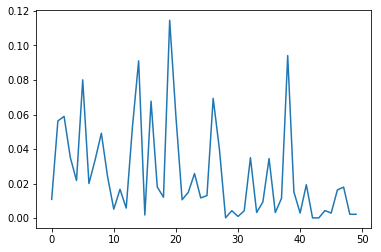

In [8]:
# Plot loss per iteration (should be going down)
losses = np.array(losses)
plt.plot(np.arange(len(losses)), losses)

[[0.6863511800765991, 0.38330399990081787, 0.2786114513874054]]


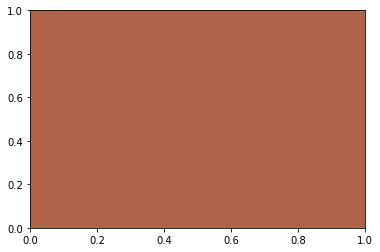

In [10]:
# Runs a new color name throught the model to predict its color
def predict(model, dataset, color_names):
    color_name_embs = [
        torch.tensor(color_dataset.to_embeddings(name, dataset.vocab_dict, dataset.embeddings)).float()
        for name in color_names
    ]
    with torch.no_grad():
        preds = []
        for emb in color_name_embs:
            pred_rgb = model(emb.view(1, emb.shape[0], -1))
            preds.append(torch.Tensor.tolist(pred_rgb.view(-1)))
        return preds
color_preds = predict(model, dataset, ['red'])
print(color_preds)
p = patches.Rectangle((0,0), 5, 5, color=color_preds[0])
fig,ax = plt.subplots(1)
ax.add_patch(p)

In [18]:
def pred_and_plot(model, dataset, color_names):
    fig = plt.figure(figsize=(15, 2))
    ax = fig.add_subplot(111)
    total_width = 400
    total_height = 200
    col_width = total_width / len(color_names)
    for i, (cn, pred) in enumerate(zip(color_names, predict(model, dataset, color_names))):
        p = patches.Rectangle((col_width*i,0), total_width, total_height, color=pred)
        ax.add_patch(p)
        ax.text(col_width*(i+0.25),total_height/2, cn)
    plt.xlim([0, total_width])
    plt.ylim([0, total_height])


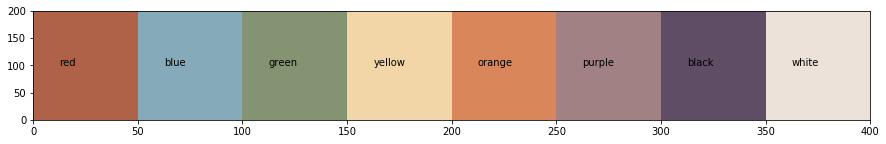

In [19]:
pred_and_plot(model, dataset, ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'black', 'white'])


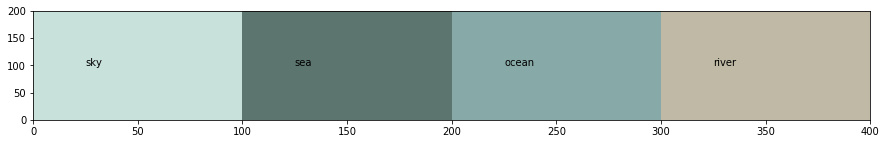

In [21]:
pred_and_plot(model, dataset, ['sky', 'sea', 'ocean', 'river'])

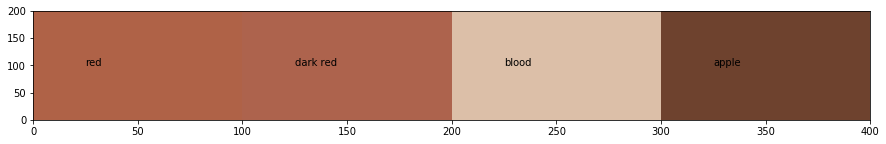

In [22]:
pred_and_plot(model, dataset, ['red', 'dark red', 'blood', 'apple'])

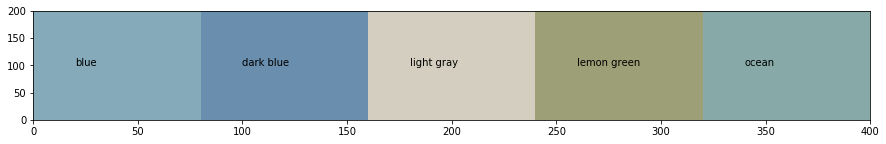

In [23]:
pred_and_plot(model, dataset, ['blue', 'dark blue', 'light gray' ,'lemon green', 'ocean'])